In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
import plotly.graph_objects as go
import plotly.express as px
import pickle

In [2]:
#import training and testing data, scale data
test = pd.read_pickle('test.pkl')
train = pd.read_pickle('train.pkl')

test["firm"] = np.where(test["firm"]=="Big 4", 0, 1)
train["firm"] = np.where(train["firm"]=="Big 4", 0, 1)

selected_features1 = train.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = train.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = train.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_train = selected_features
y_train = train["firm"]

selected_features1 = test.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = test.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = test.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_test = selected_features
y_test = test["firm"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
#import training and testing data -naive bayes
selected_features1 = train.loc[:,"ncfbus_io":"ncfo_io"]
selected_features2 = train.loc[:, "exchange_NASDAQ":"scalerevenue_cat_6"]
selected_features = selected_features1.join(selected_features2)

nb_X_train = selected_features
nb_y_train = train["firm"]

selected_features1 = test.loc[:,"ncfbus_io":"ncfo_io"]
selected_features2 = test.loc[:, "exchange_NASDAQ":"scalerevenue_cat_6"]
selected_features = selected_features1.join(selected_features2)

nb_X_test = selected_features
nb_y_test = test["firm"]

In [4]:
#import pretraining models
model_names = ["decisiontree", "knn", "randomforest", "logistic", "nb", "voting_classifier_soft", "xgboost"]

for model_name in model_names:
    with open(f"{model_name}.pkl", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_names_clean = ["Decision Tree", "KNN", "Random Forest", "Logistic Regression", "Naive Bayes", "Ensemble", "XGBoost"]
        
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names_clean, model_vars))

In [5]:
#create empty results_table
result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

In [6]:
#populate results table
for model_name, model in model_list:
    if model_name == "Naive Bayes":
        y_proba = model.predict_proba(nb_X_test)[::,1]
        fpr, tpr, _ = roc_curve(nb_y_test, y_proba)
        auc = roc_auc_score(nb_y_test, y_proba)
        result_table = result_table.append({'classifiers':model_name, 'fpr':fpr, "tpr":tpr, 'auc':auc}, ignore_index=True)
    else:
        y_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        result_table = result_table.append({'classifiers':model_name, 'fpr':fpr, "tpr":tpr, 'auc':auc}, ignore_index=True)

In [7]:
result_table

,classifiers,fpr,tpr,auc
0,Decision Tree,"[0.0, 0.01079913606911447, 0.01079913606911447...","[0.0, 0.45544554455445546, 0.5181518151815182,...",0.911704
1,KNN,"[0.0, 0.0, 0.0, 0.0021598272138228943, 0.00863...","[0.0, 0.0033003300330033004, 0.009900990099009...",0.718713
2,Random Forest,"[0.0, 0.0, 0.0, 0.0021598272138228943, 0.00215...","[0.0, 0.0033003300330033004, 0.161716171617161...",0.934913
3,Logistic Regression,"[0.0, 0.0, 0.0, 0.0021598272138228943, 0.00215...","[0.0, 0.0033003300330033004, 0.046204620462046...",0.871957
4,Naive Bayes,"[0.0, 0.0, 0.0, 0.0021598272138228943, 0.00215...","[0.0, 0.0033003300330033004, 0.066006600660066...",0.885155
5,Ensemble,"[0.0, 0.0, 0.0, 0.0021598272138228943, 0.00215...","[0.0, 0.0033003300330033004, 0.389438943894389...",0.929011
6,XGBoost,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.002159827213822894...","[0.0, 0.0033003300330033004, 0.056105610561056...",0.934663


In [8]:
result_table.set_index('classifiers', inplace=True)

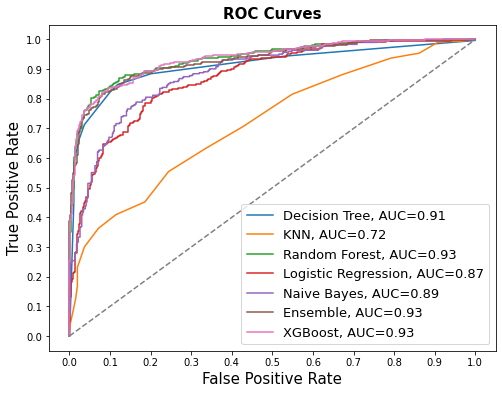

In [9]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curves', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()